### **Import Libraries**

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import urllib.request
import tarfile
import os
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Exercise 1: HOG (Histogram of Oriented Gradients) Object Detection**

Load Image

In [2]:
image_path = '/mnt/data/home.jpg'
image = cv2.imread(image_path)

Convert to Grayscale

In [3]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Apply HOG Descriptor

In [4]:
features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True)

Display Image

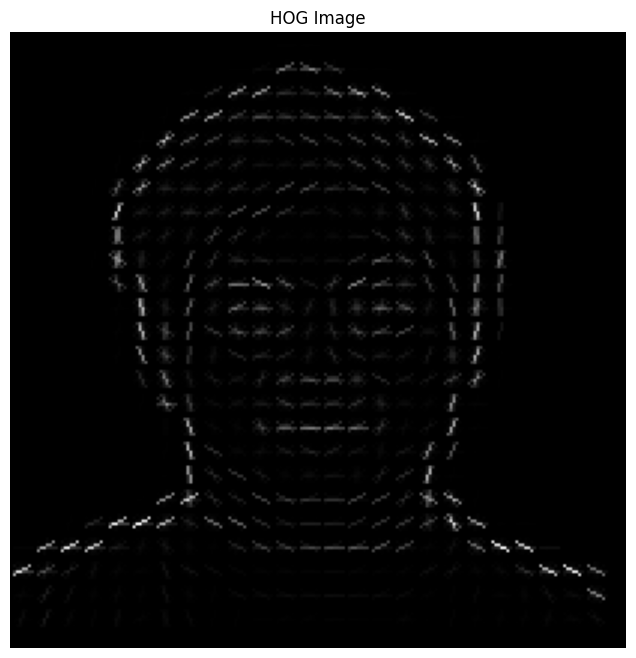

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')
plt.axis('off')
plt.show()

### Exercise 2: YOLO (You Only Look Once) Object Detection

In [6]:
!pip install opencv-python-headless

In [7]:
# Download YOLOv3 weights, config, and class names
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true -O coco.names

--2024-11-03 17:19:10--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.6’

yolov3.weights.6    100%[===================>] 236.52M  15.1MB/s    in 11s     

2024-11-03 17:19:22 (20.8 MB/s) - ‘yolov3.weights.6’ saved [248007048/248007048]

--2024-11-03 17:19:22--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg [following]
--2024-11-03 17:19:22--  https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.

### Load YOLO model and configuration

In [8]:
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

# Load class names
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

Load Image

In [9]:
image_path = '/mnt/data/home.jpg'
image = cv2.imread(image_path)

Prepare the Image for YOLO

In [10]:
height, width, _ = image1.shape
blob = cv2.dnn.blobFromImage(image1, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

Process DETECTIONS

In [11]:
# Get output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Perform detection
outs = net.forward(output_layers)

# Process detections
boxes = []
confidences = []
class_ids = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        # Temporarily comment out the confidence check
        # if confidence > 0.5:

        center_x = int(detection[0] * width)
        center_y = int(detection[1] * height)
        w = int(detection[2] * width)
        h = int(detection[3] * height)

        x = int(center_x - w / 2)
        y = int(center_y - h / 2)

        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(class_id)


# Apply Non-Max Suppression
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Draw bounding boxes
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        cv2.rectangle(image1, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image1, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

Display the Image

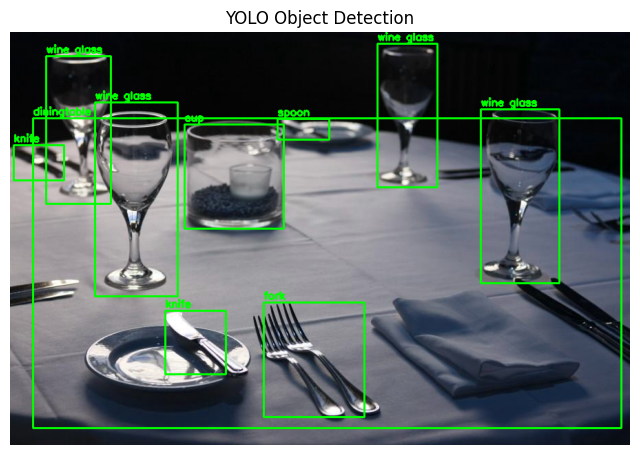

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(image1)
plt.title('YOLO Object Detection')
plt.axis('off')
plt.show()

# **Exercise 3: SSD (Single Shot MultiBox Detector)**

### Install Dependencied(if needed)

In [13]:
!pip install tensorflow opencv-python matplotlib

In [14]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

--2024-11-03 17:20:10--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.62.207, 172.253.115.207, 172.253.122.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.62.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187925923 (179M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz.6’

ssd_mobilenet_v2_co 100%[===================>] 179.22M   180MB/s    in 1.0s    

2024-11-03 17:20:11 (180 MB/s) - ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz.6’ saved [187925923/187925923]

ssd_mobilenet_v2_coco_2018_03_29/checkpoint
ssd_mobilenet_v2_coco_2018_03_29/model.ckpt.meta
ssd_mobilenet_v2_coco_2018_03_29/pipeline.config
ssd_mobilenet_v2_coco_2018_03_29/saved_model/saved_model.pb
ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
ssd_mobilenet_v2_coco_2018_03_29/saved_model/
ssd_mobilenet_v2_coco_20

### Load pre-trained SSD model

In [15]:
ssd_model = tf.saved_model.load("ssd_mobilenet_v2_coco_2018_03_29/saved_model")

### Load Image

In [16]:
image_path = '/mnt/data/home.jpg'
image = cv2.imread(image_path)

### Run the Model

In [17]:
input_tensor = tf.convert_to_tensor(image_rgb)
input_tensor = input_tensor[tf.newaxis, ...]
# Get the inference function from the SavedModel
detect_fn = ssd_model.signatures['serving_default']

# Now you can call the inference function with the input tensor
detections = detect_fn(input_tensor)

### Visualize the bounding boxes

In [18]:
detection_boxes = detections['detection_boxes'][0].numpy()
detection_classes = detections['detection_classes'][0].numpy().astype(np.int32)
detection_scores = detections['detection_scores'][0].numpy()

# Set a threshold score for displaying boxes
threshold = 0.5
height, width, _ = image.shape
for i in range(len(detection_boxes)):
    if detection_scores[i] >= threshold:
        box = detection_boxes[i] * [height, width, height, width]
        y_min, x_min, y_max, x_max = box.astype(int)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        label = str(detection_classes[i])
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


### Display the Image

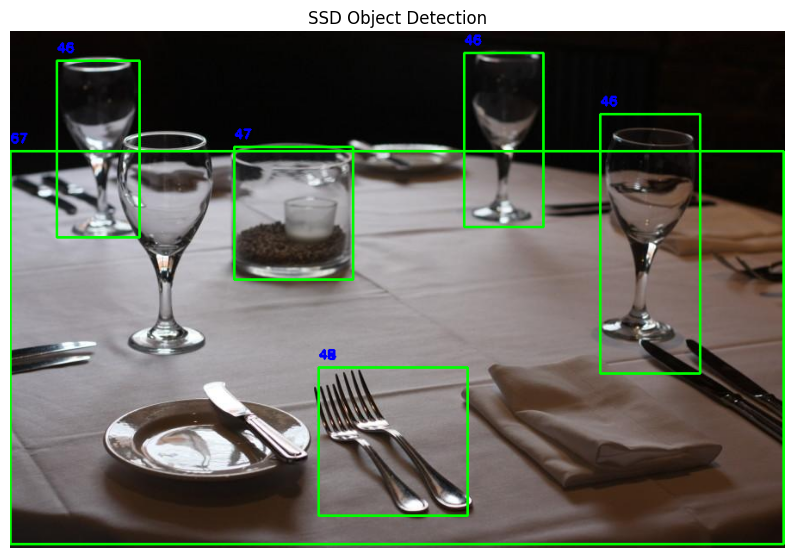

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('SSD Object Detection')
plt.axis('off')
plt.show()

# **Exercise 4: Traditional vs. Deep Learning Object Detection Comparison**

### Load the Image